# 金融信贷风控模型
## 贷中行为模型

### 1.导入所需模块



In [1]:
import pandas as pd
import numpy as np
import pickle
import random
import datetime
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn import ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
%matplotlib inline

### 2.定义时间窗口变量衍生方法

In [2]:
def DelqFeatures(event, window, type):
    """
    逾期衍生特征计算方法
    """
    current = 12
    start = 12 - window + 1
    delq1 = [event[a] for a in ['Delq1_' + str(t) for t in range(current, start - 1, -1)]]
    delq2 = [event[a] for a in ['Delq2_' + str(t) for t in range(current, start - 1, -1)]]
    delq3 = [event[a] for a in ['Delq3_' + str(t) for t in range(current, start - 1, -1)]]
    if type == 'max delq':
        if max(delq3) == 1:
            return 3
        elif max(delq2) == 1:
            return 2
        elif max(delq1) == 1:
            return 1
        else:
            return 0
    if type in ['M0 times','M1 times', 'M2 times']:
        if type.find('M0')>-1:
            return sum(delq1)
        elif type.find('M1')>-1:
            return sum(delq2)
        else:
            return sum(delq3)
        
def UrateFeatures(event, window, type):
    current = 12
    start = 12 - window + 1
    monthlySpend = [event[a] for a in ['Spend_' + str(t) for t in range(current, start - 1, -1)]]
    limit = event['Loan_Amount']
    monthlyUrate = [x / limit for x in monthlySpend]
    if type == 'mean utilization rate':
        return np.mean(monthlyUrate)
    if type == 'max utilization rate':
        return max(monthlyUrate)
    if type == 'increase utilization rate':
        currentUrate = monthlyUrate[0:-1]
        previousUrate = monthlyUrate[1:]
        compareUrate = [int(x[0]>x[1]) for x in zip(currentUrate,previousUrate)]
        return sum(compareUrate)

def PaymentFeatures(event, window, type):
    current = 12
    start = 12 - window + 1
    currentPayment = [event[a] for a in ['Payment_' + str(t) for t in range(current, start - 1, -1)]]
    previousOS = [event[a] for a in ['OS_' + str(t) for t in range(current-1, start - 2, -1)]]
    monthlyPayRatio = []
    for Pay_OS in zip(currentPayment,previousOS):
        if Pay_OS[1]>0:
            payRatio = Pay_OS[0]*1.0 / Pay_OS[1]
            monthlyPayRatio.append(payRatio)
        else:
            monthlyPayRatio.append(1)
    if type == 'min payment ratio':
        return min(monthlyPayRatio)
    if type == 'max payment ratio':
        return max(monthlyPayRatio)
    if type == 'mean payment ratio':
        total_payment = sum(currentPayment)
        total_OS = sum(previousOS)
        if total_OS > 0:
            return total_payment / total_OS
        else:
            return 1

### 3. 数据读取&查看

In [3]:
import os
folderOfData = '/home/hk/Documents/MLinLoan/chapt6/'
os.chdir(folderOfData)
trainData = pd.read_csv("traindata.csv",header = 0)
testData = pd.read_csv('testData.csv',header = 0)

In [4]:
print("train set size :nrow {}, ncol {}".format(trainData.shape[0], trainData.shape[1]))
print("test set size :nrow {}, ncol {}".format(testData.shape[0], testData.shape[1]))

train set size :nrow 28099, ncol 121
test set size :nrow 12043, ncol 76


In [5]:
trainData.head()

,CUST_ID,Loan_Amount,OS_0,OS_1,OS_2,OS_3,OS_4,OS_5,OS_6,OS_7,...,avgPayL6M,maxPayL12M,minPayL12M,avgPayL12M,M2FreqL3M_Bin,M1FreqL3M_Bin,maxDelqL1M_Bin,maxDelqL3M_Bin,maxDelqL6M_Bin,M2FreqL12M_Bin
0,5f97c74f9eee425083c9535536c96f75,90000,25947.77,86565.62,112978.46,41926.58,81568.91,40556.02,40700.32,53312.53,...,0.483302,1.000008,0.0,0.448568,0,0,0,1,2,0
1,892a7cdc80e348a8b4f38ac88cf78698,180000,99887.21,99887.21,17689.21,54578.30,108546.73,177679.61,122616.69,26987.69,...,0.358609,1.000002,0.0,0.398512,0,1,0,2,2,0
2,aa3f22edc65c441c8848bf9b552ef7af,150000,74086.91,148254.81,8696.58,67064.81,61453.20,36049.51,64204.80,14712.80,...,0.584053,1.000048,0.0,0.689325,0,1,0,2,2,0
3,13be7b52263845bd8ebc699533330e6f,60000,19569.47,43546.68,82987.16,91802.29,31247.55,28472.87,26393.94,15894.49,...,0.321862,1.000032,0.0,0.458545,0,1,2,2,2,0
4,8820e38b407446c696e5e28315cf3014,100000,50058.11,97288.48,137752.33,184847.10,8141.10,24649.20,65290.07,31820.01,...,0.789675,1.000111,0.0,0.551719,0,0,0,0,1,0


In [6]:
testData.head()

,CUST_ID,Loan_Amount,OS_0,OS_1,OS_2,OS_3,OS_4,OS_5,OS_6,OS_7,...,Delq3_4,Delq3_5,Delq3_6,Delq3_7,Delq3_8,Delq3_9,Delq3_10,Delq3_11,Delq3_12,label
0,cf031777c4fa4338b70c82a726f85aee,130000,51409.89,51409.89,125432.89,166238.80,166238.80,216749.16,90766.62,57861.35,...,1,1,0,0,0,0,0,0,0,0
1,201f5714b2e24e0896202434cb546dae,170000,73984.80,145732.36,190779.42,-0.58,-0.58,78748.78,74238.81,65353.99,...,0,0,0,0,0,0,0,0,0,0
2,3b718eaa0fef44d6ba6024d4ed5d4178,150000,52326.80,72760.75,55609.48,105063.23,201507.93,57405.56,34905.38,125096.83,...,0,0,0,0,0,0,0,0,0,0
3,816aa197a6a54e1798323fdb1b66acf1,166000,51547.20,108297.26,160025.74,22601.74,49081.14,154238.74,238809.34,119499.26,...,0,0,0,0,0,0,0,0,0,1
4,e0524b7f88974ec398e533d763461531,120000,59313.92,73233.64,77066.37,109706.92,146872.14,88873.41,52767.30,148760.22,...,0,0,0,0,0,0,0,0,0,0


In [8]:
### 检查衍生变量，训练集合中已经有了相关的衍生字段

In [7]:
for t in [1,3,6,12]:
    varname = 'M1FreqL' + str(t) + "M"
    print(trainData[varname].head())

0    0
1    0
2    0
3    1
4    0
Name: M1FreqL1M, dtype: int64
0    0
1    1
2    1
3    1
4    0
Name: M1FreqL3M, dtype: int64
0    1
1    1
2    1
3    1
4    0
Name: M1FreqL6M, dtype: int64
0    2
1    2
2    1
3    1
4    1
Name: M1FreqL12M, dtype: int64


### 3. 衍生变量计算
#### 3.1 逾期类型衍生变量 
> 逾期类型的特征在行为评分卡（预测违约行为）中，一般是非常显著的变量。
通过设定时间窗口，可以衍生以下类型的逾期变量：

>> 1. 过去1，3，6，12个月最大逾期状态【时段内最长逾期状态】
2. 过去1，3，6，12个月的M0，M1，M2 逾期次数

因为训练数据已经有了以下变量，可以不用运行

In [29]:
allFeatures = []

# 考虑过去1个月，3个月，6个月，12个月
for t in [1,3,6,12]:
    # 1，过去t时间窗口内的最大逾期状态
    allFeatures.append('maxDelqL'+str(t)+"M")
    trainData['maxDelqL'+str(t)+"M"] = trainData.apply(lambda x: DelqFeatures(x,t,'max delq'),axis=1)

    # 2，过去t时间窗口内的，M0,M1,M2的次数
    allFeatures.append('M0FreqL' + str(t) + "M")
    trainData['M0FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x,t,'M0 times'),axis=1)

    allFeatures.append('M1FreqL' + str(t) + "M")
    trainData['M1FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x, t, 'M1 times'), axis=1)

    allFeatures.append('M2FreqL' + str(t) + "M")
    trainData['M2FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x, t, 'M2 times'), axis=1)

#### 3.2 额度使用率类型变量
> 在行为评分卡模型中，额度使用率通常是与违约高度相关的
>> 1. 过去1，3，6，12个月最大月额度使用率
2. 过去1，3，6，12个月平均月额度使用率
3. 过去1，3，6，12个月额度使用率增加的月份

In [30]:

for t in [1,3,6,12]:
    
    allFeatures.append('maxUrateL' + str(t) + "M")
    trainData['maxUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x,t,'max utilization rate'),axis = 1)

    allFeatures.append('avgUrateL' + str(t) + "M")
    trainData['avgUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x, t, 'mean utilization rate'),
                                                            axis=1)

    if t > 1:
        allFeatures.append('increaseUrateL' + str(t) + "M")
        trainData['increaseUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x, t, 'increase utilization rate'),
                                                                axis=1)

#### 3.2 还款类型变量
> 在行为评分卡模型中，还款类型也是非常常用的
>> 1. 过去1，3，6，12个月最大月还款率
2. 过去1，3，6，12个月最小月还款率
3. 过去1，3，6，12个月平均月还款率

In [31]:

# 考虑过去1个月，3个月，6个月，12个月
for t in [1,3,6,12]:
    
    allFeatures.append('maxPayL' + str(t) + "M")
    trainData['maxPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'max payment ratio'),
                                                            axis=1)

    
    allFeatures.append('minPayL' + str(t) + "M")
    trainData['minPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'min payment ratio'),
                                                          axis=1)

    allFeatures.append('avgPayL' + str(t) + "M")
    trainData['avgPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'mean payment ratio'),
                                                          axis=1)


In [33]:
trainData.drop(allFeatures, axis=1).to_csv("trainsets.csv", index=None)

### 4. 数据统计与转换

> 分析过去t时间内最大的逾期状态与bad的相关度

In [34]:

trainData.groupby(['maxDelqL1M'])['label'].mean()
trainData.groupby(['maxDelqL3M'])['label'].mean()
trainData.groupby(['maxDelqL6M'])['label'].mean()
trainData.groupby(['maxDelqL12M'])['label'].mean()


maxDelqL12M
0    0.070175
1    0.044748
2    0.182365
3    0.380687
Name: label, dtype: float64

可以看出，随着逾期状态的上升，bad 比例也在同比上升

> 分析所有衍生特征的相关系数

In [35]:
for x in allFeatures:
    for y in allFeatures:
        if x!=y:
            print(x,'   ',y,'   ',np.corrcoef(trainData[x],trainData[y])[0,1])

maxDelqL1M     M0FreqL1M     0.8994108298911854
maxDelqL1M     M1FreqL1M     0.7114487658127738
maxDelqL1M     M2FreqL1M     0.3466702195765686
maxDelqL1M     maxDelqL3M     0.5037535401262918
maxDelqL1M     M0FreqL3M     0.6244427177061638
maxDelqL1M     M1FreqL3M     0.43399444898773415
maxDelqL1M     M2FreqL3M     0.20950805127537142
maxDelqL1M     maxDelqL6M     0.31233501885618725
maxDelqL1M     M0FreqL6M     0.44648312862479317
maxDelqL1M     M1FreqL6M     0.30665241063961984
maxDelqL1M     M2FreqL6M     0.1514720793821577
maxDelqL1M     maxDelqL12M     0.19915369345718267
maxDelqL1M     M0FreqL12M     0.3279801579004913
maxDelqL1M     M1FreqL12M     0.22470260927473962
maxDelqL1M     M2FreqL12M     0.12284873641357423
maxDelqL1M     maxUrateL1M     -0.0025216032531824753
maxDelqL1M     avgUrateL1M     -0.0025216032531824753
maxDelqL1M     maxUrateL3M     0.0009093225761246492
maxDelqL1M     avgUrateL3M     0.0009363792926570488
maxDelqL1M     increaseUrateL3M     0.0014950685936

> 分割离散和连续变量，以5为阈值

In [36]:
categoricalFeatures = []
numericalFeatures = []
WOE_IV_dict = {}
for var in allFeatures:
    if len(set(trainData[var])) > 5:
        numericalFeatures.append(var)
    else:
        categoricalFeatures.append(var)

> 检查bad rate在离散变量中的单调性

In [43]:
from scorecard_functions_V3 import BadRateMonotone
not_monotone =[]
for var in categoricalFeatures:

    if not BadRateMonotone(trainData, var, 'label'):
        not_monotone.append(var)

print(not_monotone)

['M1FreqL3M', 'M2FreqL3M', 'maxDelqL12M']


结果显示过去\[3个月M1逾期次数\],\[过去3个月M2逾期次数\]，\[过去12个月最大逾期状态\]非单调

In [44]:
trainData.groupby(['M2FreqL3M'])['label'].mean()

M2FreqL3M
0    0.120702
1    0.958974
2    0.963636
3    0.666667
Name: label, dtype: float64

In [45]:
trainData.groupby(['M2FreqL3M'])['label'].count()

M2FreqL3M
0    27456
1      585
2       55
3        3
Name: label, dtype: int64

过去3个月M2逾期次数的非单调性可能是变量分布不均匀导致的，需要将该变量进行合并

> 将3个月M2逾期次数进行binary化，阈值为1，并计算bad rate 和相应的woe值

In [48]:
from scorecard_functions_V3 import CalcWOE
trainData['M2FreqL3M_Bin'] = trainData['M2FreqL3M'].apply(lambda x: int(x>=1))
trainData.groupby(['M2FreqL3M_Bin'])['label'].mean()
WOE_IV_dict['M2FreqL3M_Bin'] = CalcWOE(trainData, 'M2FreqL3M_Bin', 'label')
print(WOE_IV_dict)

{'M2FreqL3M_Bin': {'WOE': {0: 0.16936574889989445, 1: -4.943841491903861}, 'IV': 0.7957473203620947}}


> 同样的方法检查3个月M1逾期次数的单调性

In [49]:
print(trainData.groupby(['M1FreqL3M'])['label'].mean())  
print(trainData.groupby(['M1FreqL3M'])['label'].count())

M1FreqL3M
0    0.049511
1    0.409583
2    0.930825
3    0.927083
Name: label, dtype: float64
M1FreqL3M
0    22379
1     4800
2      824
3       96
Name: label, dtype: int64


> 将1个月M3逾期次数进行binary化，阈值为1，并计算bad rate 和相应的woe值

In [50]:
trainData['M1FreqL3M_Bin'] = trainData['M1FreqL3M'].apply(lambda x: int(x>=1))
trainData.groupby(['M1FreqL3M_Bin'])['label'].mean()
WOE_IV_dict['M1FreqL3M_Bin'] = CalcWOE(trainData, 'M1FreqL3M_Bin', 'label')
print(WOE_IV_dict['M1FreqL3M_Bin'])

{'WOE': {0: 1.1383566599817516, 1: -1.7898564039068015}, 'IV': 1.7515413713105232}



> 对其他单调的类别型变量，检查是否有一箱的占比低于5%。 如果有，将该变量进行合并

In [51]:

small_bin_var = []
large_bin_var = []
N = trainData.shape[0]
for var in categoricalFeatures:
    if var not in not_monotone:
        total = trainData.groupby([var])[var].count()
        pcnt = total * 1.0 / N
        if min(pcnt)<0.05:
            small_bin_var.append({var:pcnt.to_dict()})
        else:
            large_bin_var.append(var)
            
            
for i in small_bin_var:
    print(i)

{'maxDelqL1M': {0: 0.6037937293142105, 1: 0.31880138083205806, 2: 0.0691839567244386, 3: 0.008220933129292857}}
{'M2FreqL1M': {0: 0.9917790668707072, 1: 0.008220933129292857}}
{'maxDelqL3M': {0: 0.22637816292394747, 1: 0.5700558738745151, 2: 0.18068258656891703, 3: 0.022883376632620377}}
{'maxDelqL6M': {0: 0.05722623580910353, 1: 0.5848962596533684, 2: 0.3128581088294957, 3: 0.04501939570803232}}
{'M2FreqL6M': {0: 0.9549806042919677, 1: 0.04003701199330937, 2: 0.004590910708566141, 3: 0.00032029609594647497, 4: 7.117691021032777e-05}}
{'M2FreqL12M': {0: 0.9233424677034769, 1: 0.0665148225915513, 2: 0.009217409872237447, 3: 0.0008185344674187694, 4: 0.00010676536531549166}}


> 对于M2FreqL1M、M2FreqL6M和M2FreqL12M，由于有部分箱占了很大比例，故删除
> 对于small_bin_var中的其他变量，将最小的箱和相邻的箱进行合并并计算WOE

In [54]:
from scorecard_functions_V3 import MergeByCondition

#allFeatures.remove('M2FreqL6M')
#allFeatures.remove('M2FreqL12M')

trainData['maxDelqL1M_Bin'] = trainData['maxDelqL1M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))
trainData['maxDelqL3M_Bin'] = trainData['maxDelqL3M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))
trainData['maxDelqL6M_Bin'] = trainData['maxDelqL6M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))

for var in ['maxDelqL1M_Bin','maxDelqL3M_Bin','maxDelqL6M_Bin']:
    WOE_IV_dict[var] = CalcWOE(trainData, var, 'label')

> 对于不需要合并、原始箱的bad rate单调的特征，直接计算WOE和IV

In [55]:
for var in large_bin_var:
    WOE_IV_dict[var] = CalcWOE(trainData, var, 'label')

> 对于数值型变量，需要先分箱，再计算WOE、IV
>> 分箱的结果需要满足：
1. 箱数不超过5
2. bad rate单调
3. 每箱占比不低于5%

In [57]:

from scorecard_functions_V3 import ChiMerge, AssignBin

bin_dict = []
for var in numericalFeatures:
    binNum = 5
    newBin = var + '_Bin'
    bin = ChiMerge(trainData, var, 'label',max_interval=binNum,minBinPcnt = 0.05)
    trainData[newBin] = trainData[var].apply(lambda x: AssignBin(x,bin))
    # 如果不满足单调性，就降低分箱个数
    while not BadRateMonotone(trainData, newBin, 'label'):
        binNum -= 1
        bin = ChiMerge(trainData, var, 'label', max_interval=binNum, minBinPcnt=0.05)
        trainData[newBin] = trainData[var].apply(lambda x: AssignBin(x, bin))
    WOE_IV_dict[newBin] = CalcWOE(trainData, newBin, 'label')
    bin_dict.append({var:bin})

TypeError: list indices must be integers or slices, not float

### 5. 单变量与多变量分析
> 选取IV高于0.02的变量

In [58]:
high_IV = [(k,v['IV']) for k,v in WOE_IV_dict.items() if v['IV'] >= 0.02]
high_IV_sorted = sorted(high_IV, key=lambda k: k[1],reverse=True)
for (var,iv) in high_IV:
    newVar = var+"_WOE"
    trainData[newVar] = trainData[var].map(lambda x: WOE_IV_dict[var]['WOE'][x])


saveFile = open(folderOfData+'trainData.pkl','w')
pickle.dump(trainData,saveFile)
saveFile.close()



saveFile = open(folderOfData+'trainData.pkl','r')
trainData = pickle.load(saveFile)
saveFile.close()

TypeError: write() argument must be str, not bytes

> 多变量分析：比较两两线性相关性。如果相关系数的绝对值高于阈值，剔除IV较低的一个

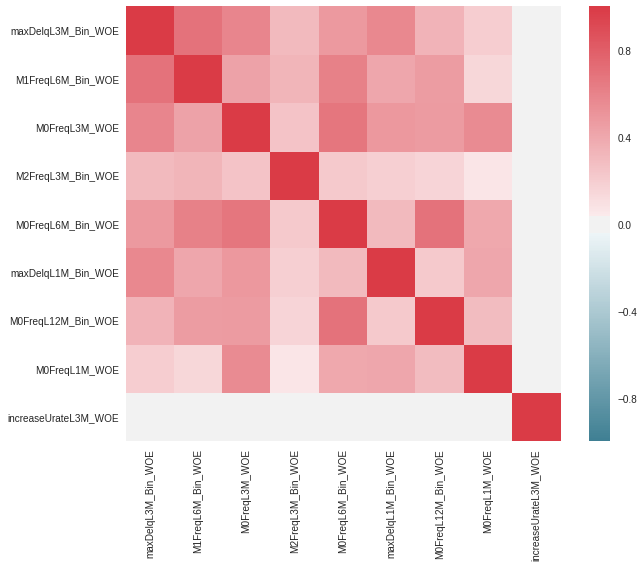

In [59]:
deleted_index = []
cnt_vars = len(high_IV_sorted)
for i in range(cnt_vars):
    if i in deleted_index:
        continue
    x1 = high_IV_sorted[i][0]+"_WOE"
    for j in range(cnt_vars):
        if i == j or j in deleted_index:
            continue
        y1 = high_IV_sorted[j][0]+"_WOE"
        roh = np.corrcoef(trainData[x1],trainData[y1])[0,1]
        if abs(roh)>0.7:
            x1_IV = high_IV_sorted[i][1]
            y1_IV = high_IV_sorted[j][1]
            if x1_IV > y1_IV:
                deleted_index.append(j)
            else:
                deleted_index.append(i)

single_analysis_vars = [high_IV_sorted[i][0]+"_WOE" for i in range(cnt_vars) if i not in deleted_index]


X = trainData[single_analysis_vars]
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)

> 方差膨胀因子VIF计算

In [62]:
from scorecard_functions_V3 import variance_inflation_factor
X = np.matrix(trainData[single_analysis_vars])
VIF_list = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(max(VIF_list))


ImportError: cannot import name 'variance_inflation_factor'

### 6. 模型训练

In [64]:
multi_analysis = single_analysis_vars
X = trainData[multi_analysis]
X['intercept'] = [1] * X.shape[0]
y = trainData['label']
logit = sm.Logit(y, X)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']
fit_result = fit_result.sort_values(by = 'coef')

Optimization terminated successfully.
         Current function value: 0.271459
         Iterations 7


/home/hk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
fit_result

,coef,p-value
intercept,-1.798926,0.000000e+00
increaseUrateL3M_WOE,-1.540915,5.663361e-98
maxDelqL3M_Bin_WOE,-0.662705,6.975411e-150
M2FreqL3M_Bin_WOE,-0.651237,4.846166e-60
M0FreqL3M_WOE,-0.452682,2.330512e-40
maxDelqL1M_Bin_WOE,-0.171262,1.273231e-08
M1FreqL6M_Bin_WOE,-0.165608,2.145736e-06
M0FreqL12M_Bin_WOE,-0.011158,8.219690e-01
M0FreqL6M_Bin_WOE,0.123731,8.041259e-03
M0FreqL1M_WOE,0.322719,5.269703e-05


> 单独建立回归模型，系数为负，与预期相符，说明仍然存在多重共线性

In [70]:
sm.Logit(y, trainData['increaseUrateL3M_WOE']).fit().params  # -0.995312
#sm.Logit(y, trainData['minPayL6M_Bin_WOE']).fit().params  # -0.807779
#sm.Logit(y, trainData['avgUrateL12M_Bin_WOE']).fit().params  # -1.0179
#sm.Logit(y, trainData['minPayL1M_Bin_WOE']).fit().params  #  -0.969236
sm.Logit(y, trainData['M0FreqL6M_Bin_WOE']).fit().params  # -1.032842
#sm.Logit(y, trainData['minPayL3M_Bin_WOE']).fit().params  #  -0.829298

Optimization terminated successfully.
         Current function value: 0.682128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613547
         Iterations 5


M0FreqL6M_Bin_WOE   -1.032842
dtype: float64

> 下一步，用GBDT跑出变量重要性，挑选出合适的变量

In [71]:
clf = ensemble.GradientBoostingClassifier()
gbdt_model = clf.fit(X, y)
importace = gbdt_model.feature_importances_.tolist()
featureImportance = zip(multi_analysis,importace)
featureImportanceSorted = sorted(featureImportance, key=lambda k: k[1],reverse=True)

In [72]:
print(featureImportanceSorted)

[('maxDelqL3M_Bin_WOE', 0.2549681432108126), ('increaseUrateL3M_WOE', 0.18419396449825703), ('M1FreqL6M_Bin_WOE', 0.16323212761195877), ('M0FreqL3M_WOE', 0.11788285100267828), ('maxDelqL1M_Bin_WOE', 0.0870198007790952), ('M2FreqL3M_Bin_WOE', 0.07869274322984579), ('M0FreqL12M_Bin_WOE', 0.06146611083912603), ('M0FreqL6M_Bin_WOE', 0.04655741832507016), ('M0FreqL1M_WOE', 0.005986840503156207)]


> 先假定模型可以容纳5个特征，再逐步增加特征个数，直到有特征的系数为正，或者p值超过0.1

In [ ]:
n = 5
featureSelected = [i[0] for i in featureImportanceSorted[:n]]
X_train = X[featureSelected+['intercept']]
logit = sm.Logit(y, X_train)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']

![](http://chart.googleapis.com/chart?cht=tx&chl= 在此插入Latex公式)

$ f(x) = x $

$$ s = \sum_1^n{n_i} $$

$$ \lbrace a+x \rbrace $$

$$ \langle x + y \rangle $$

$$ \lceil \frac{x}{2} \rceil $$

$$ \lfloor x \rfloor $$

$$
{a+1 \over b+1}
$$

$$  \vec{x} $$

$$  
mse = \sum_{n=i}^{n}(y_i-{\hat{y_i}})^2
$$

$$ 
\log(p \div (1 - p))
$$